In [1]:
import os
import re
import json
import logging

import PIL
import cv2
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
def subimage(img, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.

    Reference: 
    https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python
    '''

    # Uncomment for theta in radians
    #theta *= 180/np.pi
    
    image = img.copy()
    shape = ( image.shape[1], image.shape[0] ) # cv2.warpAffine expects shape in (length, height)
    
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 )
    image = cv2.warpAffine( src=image, M=matrix, dsize=shape )

    x = int( center[0] - width/2  )
    y = int( center[1] - height/2 )

    image = image[ y:y+height, x:x+width ]
    
    # my part
    px, py = np.where((image[:, :, 0] != 0) & (image[:, :, 1] != 0) & (image[:, :, 2] != 0))
    x_max, x_min = np.max(px), np.min(px)
    y_max, y_min = np.max(py), np.min(py)
    
    chunk = image[x_min:x_max, y_min:y_max, :].copy()
    del(image) # somehow there is a memory leak
    return chunk

def get_tilt(coord):
    # index 0 is the top left corner
    d = np.linalg.norm(coord[0] - coord, axis=1)
    idx_second_longest = d.argsort()[-2]
    
    # get direction vector
    vec = np.array(coord[idx_second_longest] - coord[0], dtype=float) 
    vec /= np.linalg.norm(vec)
    
    # align all the car respect to x axis
    ang = np.arccos(vec.dot([1, 0])) * 180 / np.pi
    pos = np.sign(np.cross([1, 0], vec))
    ang = pos*ang
    
    return ang

def load_images_cv(path, filter_car=False):
    """Load images using opencv which is much faster than PIL"""
    ret = cv2.imread(path)
    
    if ret is None:
        raise RuntimeError(f"{path} is not exists.")
        
    ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    if filter_car:
        r = ret[:, :, 0] == 255
        b = ret[:, :, 1] == 255
        g = ret[:, :, 2] == 0
        ret = r * b * g    
        
    return ret

def load_cars_bbox(path):
    coords = []
    
    with open(path, "r") as f:
        data = json.load(f)
        
        labels = data["labels"]
        polygons = data["polygons"]
        
        for label, polyon in zip(labels, polygons):
            if label == "car":    
                coords.append(np.array(polyon["coordinates"][0][:-1], dtype=int))
                
    return coords

def crop_car(img, coord, buffer=5):
    ang = get_tilt(coord)
    r, c, _ = img.shape

    x_min, x_max = max(0, coord[:, 0].min() - buffer), min(r, coord[:, 0].max() + buffer)
    y_min, y_max = max(0, coord[:, 1].min() - buffer), min(c, coord[:, 1].max() + buffer)
    
    w, h = x_max - x_min, y_max - y_min
    cx, cy = (x_max + x_min)//2, (y_min + y_max)//2
    car_aligned = subimage(img, (cx, cy), ang, max(w, h), min(h, w))
    
    car_orignal = img[y_min:y_max, x_min:x_max, :]
    
    return car_orignal, car_aligned

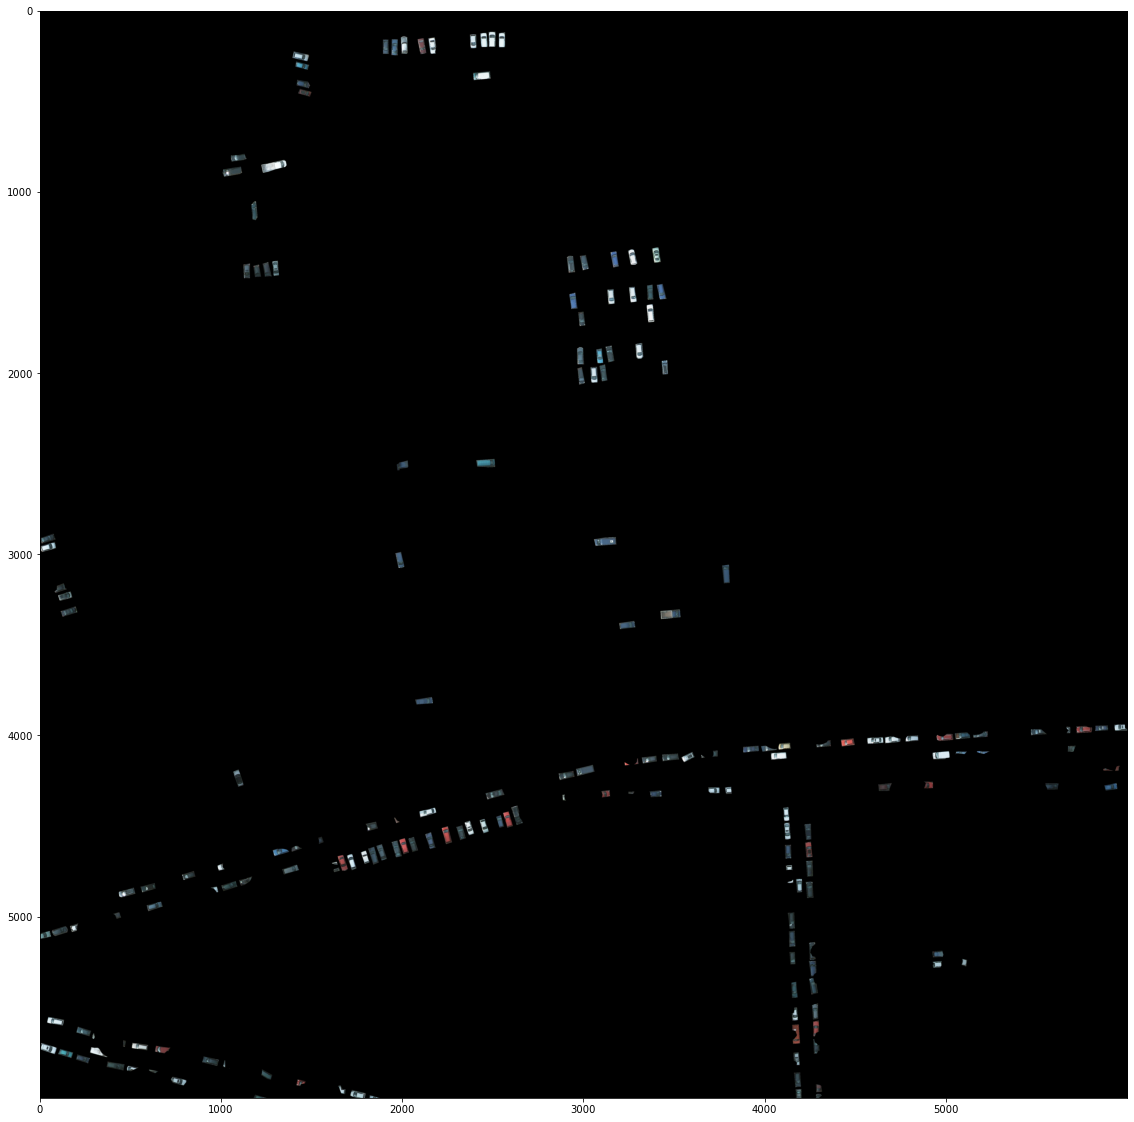

In [5]:
mask = load_images_cv('../data/training/top_potsdam_6_8_label.tif', True)
img = load_images_cv('../data/training/top_potsdam_6_8_RGB.tif', False)
img_filtered = img * mask[:, :, None]
plt.figure(figsize=(20, 20))
plt.imshow(img_filtered)

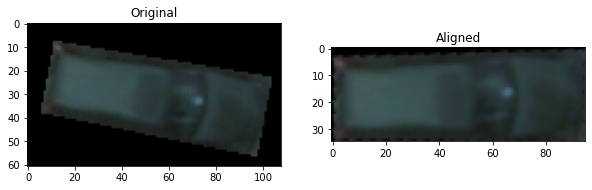

In [6]:
coords = load_cars_bbox('../data/training/top_potsdam_6_8_annos.json')
x = coords[14]
buffer = 5

car_original, car_aligned = crop_car(img_filtered, x, buffer)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(car_original)

plt.subplot(1, 2, 2)
plt.title("Aligned")
plt.imshow(car_aligned)

In [41]:
# prameters
buffer = 5
treshold = 0.9
ratio = 2
data_path = "../data/training"

test1 = "top_potsdam_2_10_RGB.tif"
test2 = "top_potsdam_2_10_label.tif"
test3 = "top_potsdam_2_10_annos.json"
exp = r"top_potsdam_([0-9]+_[0-9]+)_(RGB|label|annos).[tif|json]"

assert re.search(exp, test1).groups() == ("2_10", "RGB")
assert re.search(exp, test2).groups() == ("2_10", "label")
assert re.search(exp, test3).groups() == ("2_10", "annos")

data_dict = {}
for f in os.listdir(data_path):
    if os.path.splitext(f)[-1] in [".tif", ".json"]:
        m = re.search(exp, f)
        if m:
            tile_id, image_type = m.groups()
            res = data_dict.get(tile_id, [None, None, None])
            if image_type == "label":
                res[1] = os.path.join(data_path, f)
            elif image_type == "RGB":
                res[0] = os.path.join(data_path, f)
            else:
                res[2] = os.path.join(data_path, f)
            data_dict[tile_id] = res

cars = []
for key in data_dict:
    rgb_path, label_path, annot_path = data_dict[key]
    print(f"::Reading RBG => {rgb_path}")
    print(f"::Reading Label => {label_path}")
    print(f"::Reading Annotation => {annot_path}")
    
    mask = load_images_cv(label_path, True)
    img = load_images_cv(rgb_path, False)
    img_filtered = img * mask[:, :, None]
    
    coords = load_cars_bbox(annot_path)
    print(f"::Total number of unique cars => {len(coords)}")
    
    # ignore ground
    for i, coord in enumerate(coords):
        try:
            car_original, car_aligned = crop_car(img_filtered, coord, buffer)
            r, c, _ = car_aligned.shape
            car_area = np.sum((car_aligned[:, :, 0] != 0) & \
                          (car_aligned[:, :, 1] != 0) & \
                          (car_aligned[:, :, 2] != 0))
            background_area = r*c
            if r < 20:
                raise RuntimeError(f"Image height is short ({r}))") 
            if r == 0 or c == 0:
                raise RuntimeError(f"Image has empty rows ({r}) or cols ({c})")
            elif car_area / background_area < treshold:
                raise RuntimeError(
                    f"Mask of car is not complete, ratio of car and background is {car_area / (r*c)}")
            elif c < ratio*r:
                raise RuntimeError(
                    f"Aspect ratio of car is not correct rows ({r}) and cols ({c})")
        except Exception as e:
            #print(f"::Failed => {e}")
            continue
        cars.append(car_aligned)
    print("-----"*10)
        
    

::Reading RBG => ../data/training/top_potsdam_6_8_RGB.tif
::Reading Label => ../data/training/top_potsdam_6_8_label.tif
::Reading Annotation => ../data/training/top_potsdam_6_8_annos.json
::Total number of unique cars => 191


<ipython-input-4-ed5836769710>:40: RuntimeWarning: invalid value encountered in true_divide
  vec /= np.linalg.norm(vec)


--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_6_10_RGB.tif
::Reading Label => ../data/training/top_potsdam_6_10_label.tif
::Reading Annotation => ../data/training/top_potsdam_6_10_annos.json
::Total number of unique cars => 275
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_3_11_RGB.tif
::Reading Label => ../data/training/top_potsdam_3_11_label.tif
::Reading Annotation => ../data/training/top_potsdam_3_11_annos.json
::Total number of unique cars => 167
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_7_11_RGB.tif
::Reading Label => ../data/training/top_potsdam_7_11_label.tif
::Reading Annotation => ../data/training/top_potsdam_7_11_annos.json
::Total number of unique cars => 346
--------------------------------------------------
::Reading RBG => ../data/training/top_potsdam_6_11_RGB.tif
::Reading Label => ../data/training/top_potsdam_6_11_

In [59]:
# save each car
data_parent_folder = os.path.split(data_path)[0]
train_cars_folder = os.path.join(data_parent_folder, "train_cars")
if not os.path.isdir(train_cars_folder):
    os.makedirs(train_cars_folder)
np.save(os.path.join(train_cars_folder, "cars.npy"), np.array(cars, dtype="object"))
for i, car in enumerate(cars):
    car_path = os.path.join(train_cars_folder, "car_%d.png" % i)
    
    cv2.imwrite(car_path, car)

In [65]:
anno = "../data/cem-v0/vehicles_600_carssmalltrucks_outside_bnr10-bnf-defo0.05/annotations.json"

In [66]:
with open(anno, "r") as f:
    data = json.load(f)

In [68]:
data[0]

{'image_filename': 'image_00000.jpg',
 'annotations': {'labels': ['car',
   'car',
   'car',
   'car',
   'car',
   'car',
   'car',
   'car',
   'car',
   'car'],
  'polygons': [{'type': 'Polygon',
    'coordinates': [[[458.0900229724978, 526.0],
      [458.0900229724978, 566.0409667525648],
      [362.0, 566.0409667525648],
      [362.0, 526.0],
      [458.0900229724978, 526.0]]]},
   {'type': 'Polygon',
    'coordinates': [[[497.7507214346394, 363.0],
      [497.7507214346394, 409.9008090525605],
      [396.0, 409.9008090525605],
      [396.0, 363.0],
      [497.7507214346394, 363.0]]]},
   {'type': 'Polygon',
    'coordinates': [[[539.0651428173267, 57.0],
      [539.0651428173267, 95.04445300014966],
      [471.0, 95.04445300014966],
      [471.0, 57.0],
      [539.0651428173267, 57.0]]]},
   {'type': 'Polygon',
    'coordinates': [[[583.7032513469763, 562.0],
      [583.7032513469763, 596.5843278419266],
      [530.0, 596.5843278419266],
      [530.0, 562.0],
      [583.703251346

In [ ]:
def load_cars_bbox(path):
    coords = []
    
    with open(path, "r") as f:
        data = json.load(f)
        
        labels = data["labels"]
        polygons = data["polygons"]
        
        for label, polyon in zip(labels, polygons):
            if label == "car":    
                coords.append(np.array(polyon["coordinates"][0][:-1], dtype=int))
                
    return coords